In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import random

In [15]:
df = pd.read_parquet("/Users/ayush/Documents/University/Year 03/Sem 01/DATA3888/Optiver-07/Data/FE30Stocks.parquet")

In [16]:
window_size = 30                    
batch_size  = 512                    
val_frac    = 0.1 

In [17]:
feature_cols = ['stock_id', 'mid_price', 'spread',
       'imbalance', 'book_pressure', 'LOB_entropy', 'log_return',
       'bipower_var', 'log_wap_return', 'imbalance_lag1', 'imbalance_lag2',
       'book_pressure_lag1', 'book_pressure_lag2', 'log_return_lag1',
       'log_return_lag2', 'rolling_vol_30', 'rolling_imbalance_mean_30',
       'sec_sin', 'sec_cos', 'bid_size1_log', 'ask_size1_log', 'bid_size2_log',
       'ask_size2_log']
target_col = "rv_future"

In [18]:
df['rv_future_log'] = np.log1p(df['rv_future'])
feature_cols_mod = [c for c in feature_cols if c!='rv_future'] 
target_col_mod     = 'rv_future_log'

In [19]:
df['rv_future_log'] = np.log1p(df['rv_future'])

In [20]:
unique_sessions = df["time_id"].sort_values().unique()
cut1 = int(len(unique_sessions)*0.8)
train_sessions = unique_sessions[:cut1]
test_sessions  = unique_sessions[cut1:]

In [21]:
cut2 = int(len(train_sessions)*0.9)
val_sessions   = train_sessions[cut2:]
train_sessions = train_sessions[:cut2]

In [22]:
train_df = df[df["time_id"].isin(train_sessions)]
val_df   = df[df["time_id"].isin(val_sessions)]
test_df  = df[df["time_id"].isin(test_sessions)]

In [ ]:
x_scaler = MinMaxScaler().fit(train_df[feature_cols_mod])
y_scaler = MinMaxScaler().fit(train_df[[target_col_mod]])

for split in (train_df, val_df, test_df):
    split[feature_cols_mod] = x_scaler.transform(split[feature_cols_mod])
    split[[target_col_mod]] = y_scaler.transform(split[[target_col_mod]])

In [24]:
def make_ds(df_split, seq_len, batch_size, shuffle=False):
    # extract numpy arrays
    X = df_split[feature_cols_mod].values.astype("float32")
    y = df_split[target_col_mod].values.astype("float32")[seq_len:]  # align

    return tf.keras.utils.timeseries_dataset_from_array(
        data=X,
        targets=y,
        sequence_length=seq_len,
        sequence_stride=1,
        shuffle=shuffle,
        batch_size=batch_size
    ).prefetch(tf.data.AUTOTUNE)

SEQ_LEN = 30
BATCH   = 64

train_ds = make_ds(train_df, SEQ_LEN, BATCH, shuffle=True)
val_ds   = make_ds(val_df,   SEQ_LEN, BATCH)
test_ds  = make_ds(test_df,  SEQ_LEN, BATCH)

In [25]:
def qlike_loss(y_true, y_pred):
    ratio = tf.clip_by_value(y_true, 1e-10, np.inf) / tf.clip_by_value(y_pred, 1e-10, np.inf)
    return tf.reduce_mean(ratio - tf.math.log(ratio) - 1.0)

In [26]:
class R2Metric(tf.keras.metrics.Metric):
    def __init__(self, name='R2', **kwargs):
        super().__init__(name=name, **kwargs)
        self.sse = self.add_weight(name='sse', initializer='zeros')
        self.sst = self.add_weight(name='sst', initializer='zeros')
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true, y_pred = tf.squeeze(y_true), tf.squeeze(y_pred)
        self.sse.assign_add(tf.reduce_sum(tf.square(y_true - y_pred)))
        self.sst.assign_add(tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true))))
    def result(self):
        return 1 - (self.sse / (self.sst + 1e-12))
    def reset_states(self):
        self.sse.assign(0.); self.sst.assign(0.)

In [27]:
num_feats = len(feature_cols)
def build_lstm_model(seq_len, num_features):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(seq_len, num_features)))
    model.add(Dropout(0.2))
    model.add(LSTM(32))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))  
    return model

In [28]:
model = build_lstm_model(SEQ_LEN, len(feature_cols_mod))

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    # ModelCheckpoint('best_lstm_mse_model.h5', save_best_only=True)
]

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='mse',
    metrics=['mae', 'mse', qlike_loss, R2Metric(name='r2')]
)

model.summary()

/Users/ayush/Documents/University/Year 03/Sem 01/DATA3888/Optiver-07/volt/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        22,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,489 (138.63 KB)

 Trainable params: 35,489 (138.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=2, 
    callbacks=callbacks, 
    verbose=1
)

In [ ]:
hist = history.history

print("Final metrics:")
print(f"  Train QLIKE : {hist['qlike_loss'][-1]:.9f}")
print(f"  Train R²    : {hist['r2'][-1]:.9f}")
print(f"  Val QLIKE   : {hist['val_qlike_loss'][-1]:.9f}")
print(f"  Val R²      : {hist['val_r2'][-1]:.9f}")

Final metrics:
  Train QLIKE : 3995.246582031
  Train R²    : 0.591264129
  Val QLIKE   : 0.085266732
  Val R²      : -1.074222803


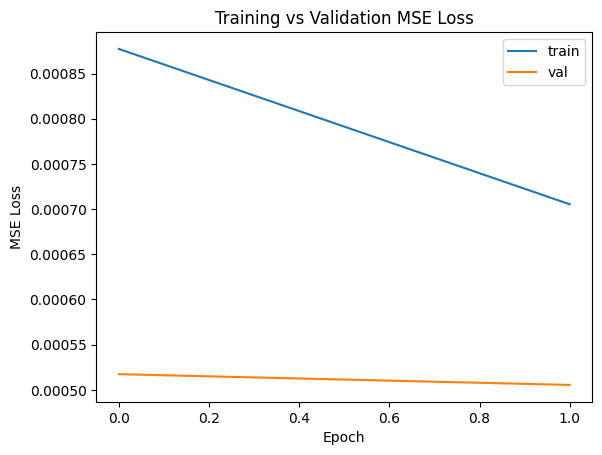

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training vs Validation MSE Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend(['train','val'])
plt.show()

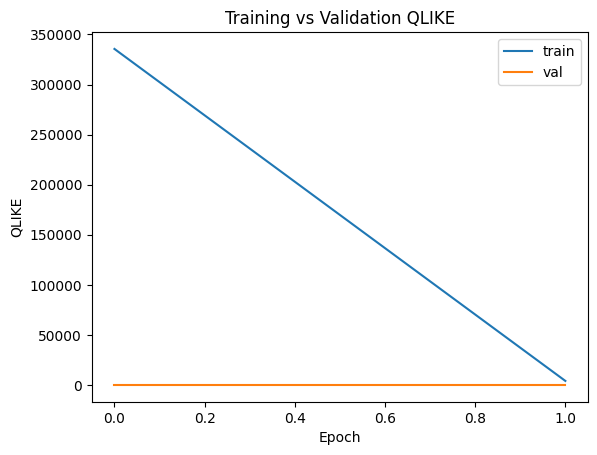

In [ ]:
if 'qlike_loss' in history.history:
    plt.figure()
    plt.plot(history.history['qlike_loss'])
    plt.plot(history.history['val_qlike_loss'])
    plt.title('Training vs Validation QLIKE')
    plt.xlabel('Epoch')
    plt.ylabel('QLIKE')
    plt.legend(['train','val'])
    plt.show()

In [ ]:
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
y_pred = model.predict(test_ds).squeeze()

4370/4370 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step


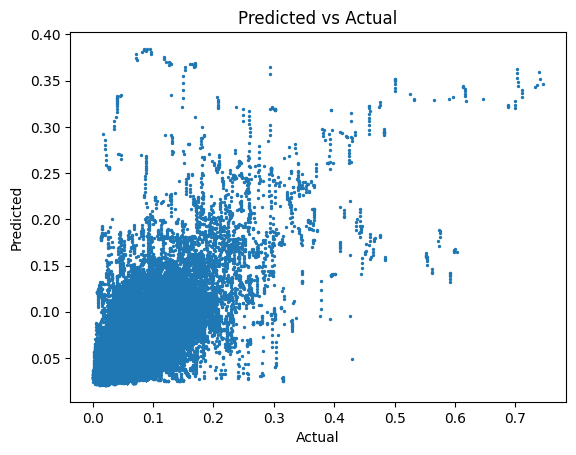

In [ ]:
plt.figure()
plt.scatter(y_true, y_pred, s=2)
plt.title('Predicted vs Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

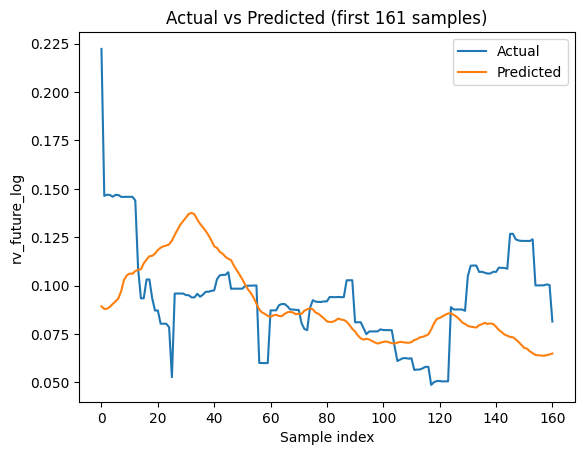

In [ ]:
N = 161
plt.figure()
plt.plot(y_true[:N])
plt.plot(y_pred[:N])
plt.title(f'Actual vs Predicted (first {N} samples)')
plt.xlabel('Sample index')
plt.ylabel(target_col_mod)
plt.legend(['Actual','Predicted'])
plt.show()